**Datasets:**
`<clean/noisy>-<noise level in mm>-<filter>-<pid/dwa>-<strategy>-<g/r>-<before/after>-<no>.csv`

Clean:
- 

Noisy:
- 

FIR:
-

Kalman:
1. var x = 25; cov = 0
2. var x = 25; cov = 25
3. var x = 0.01; cov = 0
4. var x = 0.00001; cov = 0

In [155]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Union
import warnings

warnings.filterwarnings('ignore')

NO_ROBOTS = 6
ROBOT_RANGE = range(NO_ROBOTS)
NO_ROWS = 1000  # Limit window to be analysed
X_AXES = np.arange(NO_ROWS)

CLEAN = "clean-pid-ss-r.csv"
NOISY = "noisy-25-pid-ss-r.csv"
CLEAN_KALMAN = "clean-fir-pid-ss-r-after.csv"
NOISY_KALMAN = "noisy-25-fir-pid-ss-r-after.csv"

V_COL = "vector"
ID_COL, X_COL, Y_COL, TH_COL = "id", "x", "y", "orientation"
COLS = [X_COL, Y_COL, TH_COL]
COLS_ALL = COLS + [ID_COL]


def format_data(filename: str, id: bool = True) -> pd.DataFrame:  # for all 6 robots
    data = pd.read_csv(filename)
    if id:
        return data[COLS_ALL]
    return data[COLS].iloc[:NO_ROWS]


CLEAN_FD = format_data(CLEAN)
NOISY_FD = format_data(NOISY)
CLEAN_KALMAN_FD = format_data(CLEAN_KALMAN)
NOISY_KALMAN_FD = format_data(NOISY_KALMAN)


def extract_robot(data: pd.DataFrame, id: int) -> pd.DataFrame:
    return data[data[ID_COL]==id].iloc[:NO_ROWS].drop(ID_COL, axis=1).reset_index(drop=True)


cleans   = [extract_robot(CLEAN_FD, id) for id in ROBOT_RANGE]
noisys   = [extract_robot(NOISY_FD, id) for id in ROBOT_RANGE]
clean_ks = [extract_robot(CLEAN_KALMAN_FD, id) for id in ROBOT_RANGE]
noisy_ks = [extract_robot(NOISY_KALMAN_FD, id) for id in ROBOT_RANGE]


def get_current_ax(axs: np.ndarray, id: int) -> plt.Axes:
    return axs[id//3][id%3]

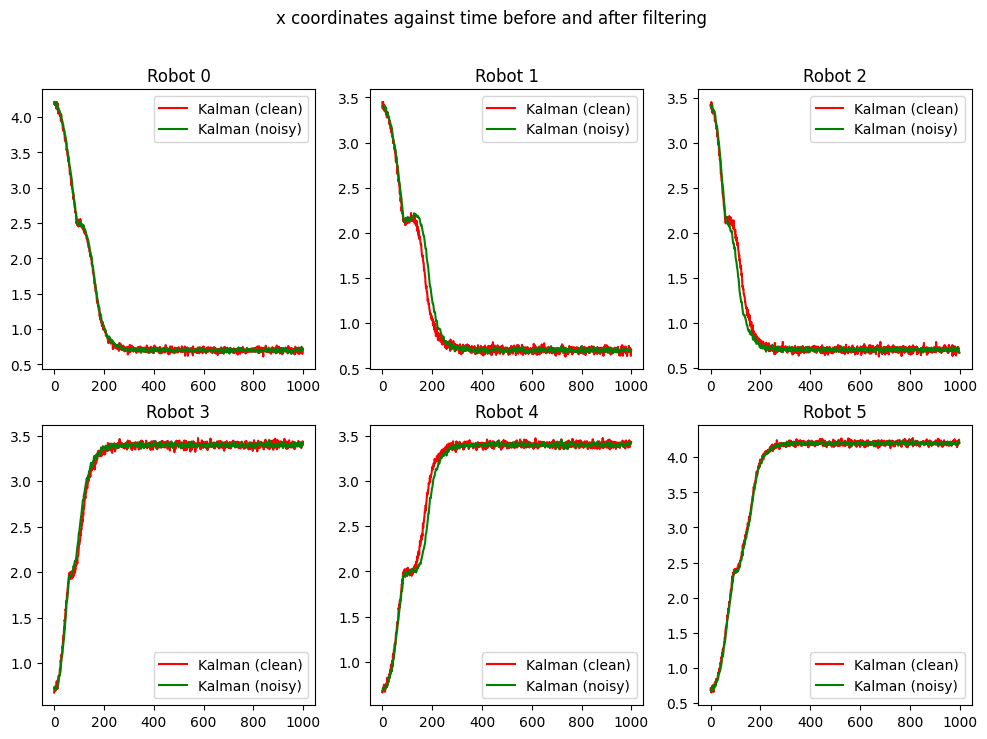

In [156]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("x coordinates against time before and after filtering")

for id in ROBOT_RANGE:
    clean = cleans[id]
    noisy = noisys[id]
    clean_k = clean_ks[id]
    noisy_k = noisy_ks[id]
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    # current_ax.plot(X_AXES, clean_k[X_COL], "b")
    current_ax.plot(X_AXES, noisy[X_COL], "r")
    current_ax.plot(X_AXES, noisy_k[X_COL], "g")
    # current_ax.plot(X_AXES, clean[X_COL], "k")
    
    current_ax.legend(("Kalman (clean)", "Kalman (noisy)", "Noisy", "Clean"))

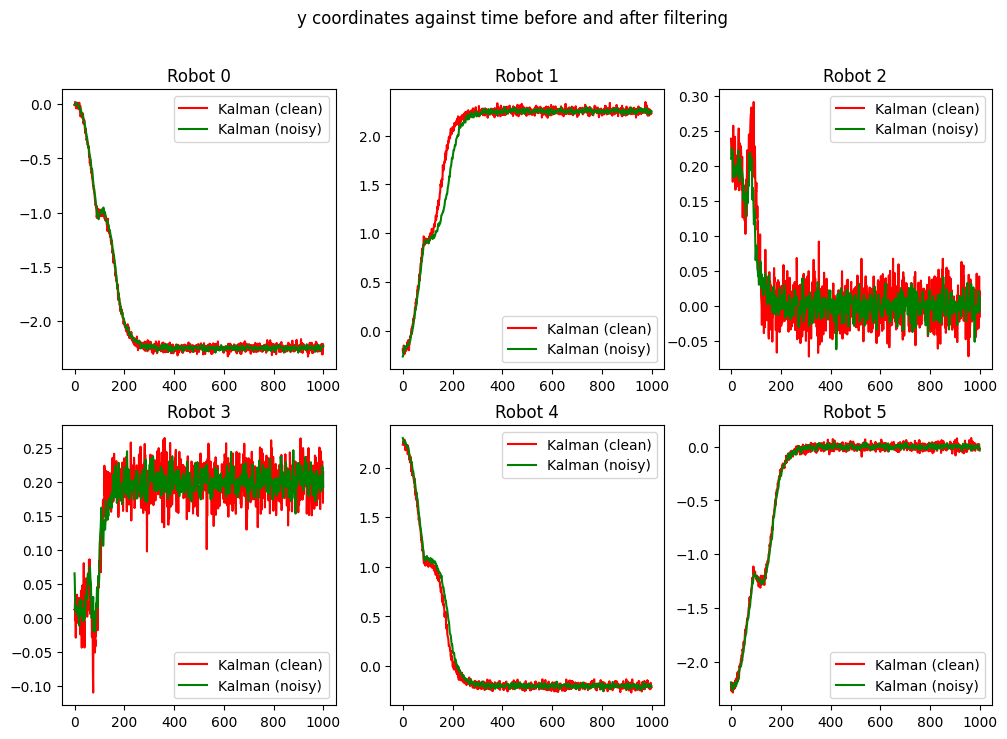

In [157]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("y coordinates against time before and after filtering")

for id in ROBOT_RANGE:
    clean = cleans[id]
    noisy = noisys[id]
    clean_k = clean_ks[id]
    noisy_k = noisy_ks[id]
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    # current_ax.plot(X_AXES, clean_k[Y_COL], "b")
    current_ax.plot(X_AXES, noisy[Y_COL], "r")
    current_ax.plot(X_AXES, noisy_k[Y_COL], "g")
    # current_ax.plot(X_AXES, clean[Y_COL], "k")
    
    current_ax.legend(("Kalman (clean)", "Kalman (noisy)", "Noisy", "Clean"))

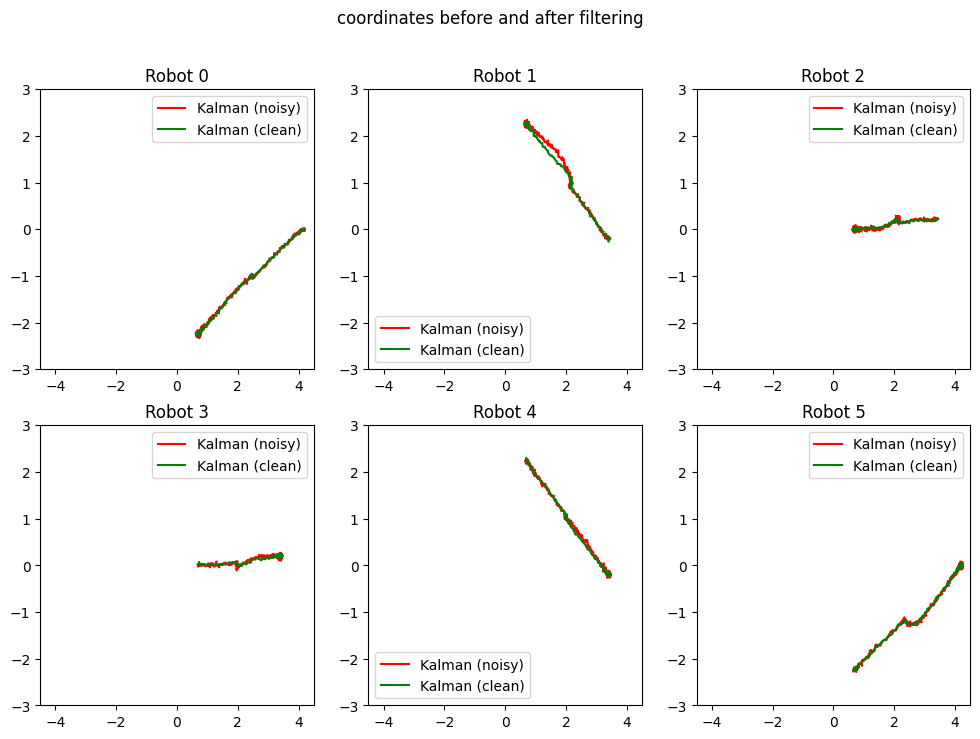

In [158]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("coordinates before and after filtering")

for id in ROBOT_RANGE:
    clean = cleans[id]
    noisy = noisys[id]
    noisy_k = noisy_ks[id]
    clean_k = clean_ks[id]
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.set_xlim(-4.5, 4.5)
    current_ax.set_ylim(-3, 3)
    
    # current_ax.plot(clean_k[X_COL], clean_k[Y_COL], "b")
    current_ax.plot(noisy[X_COL], noisy[Y_COL], "r")
    current_ax.plot(noisy_k[X_COL], noisy_k[Y_COL], "g")
    # current_ax.plot(clean[X_COL], clean[Y_COL], "k")
    
    current_ax.legend(("Kalman (noisy)", "Kalman (clean)", "Noisy", "Clean"))

In [159]:
def percentage_diff(
    old: float,
    new: float
) -> float:
    return round((new-old) / old * 100, 1)


def diff_squared(t: float, a: float) -> float:
    return (t - a) ** 2


def mean_squared_error(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame,
    param: str,
    id: Union[int, None] = None
    ) -> float:
    if id is not None:
        true_data = extract_robot(true_data, id)
        actual_data = extract_robot(actual_data, id)
        
    return true_data[param].combine(
            other=actual_data[param],
            func=diff_squared
        ).mean()


def vectorify(x: float, y: float) -> np.ndarray:
    return np.array((x, y))


def mean_squared_error_vec(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame,
    id: Union[int, None] = None
    ) -> float:
    if id is not None:
        true_data = extract_robot(true_data, id)
        actual_data = extract_robot(actual_data, id)
    
    true_vec = true_data[X_COL].combine(
        other=true_data[Y_COL],
        func=vectorify
    )
    
    actual_vec = actual_data[X_COL].combine(
        other=actual_data[Y_COL],
        func=vectorify
    )
    
    return (np.linalg.norm(true_vec - actual_vec) ** 2).mean()


baseline_xs = [mean_squared_error(CLEAN_FD, NOISY_FD, X_COL, id) for id in ROBOT_RANGE]

baseline_ys = [mean_squared_error(CLEAN_FD, NOISY_FD, Y_COL, id) for id in ROBOT_RANGE]

baseline_vs = [mean_squared_error_vec(CLEAN_FD, NOISY_FD, id) for id in ROBOT_RANGE]

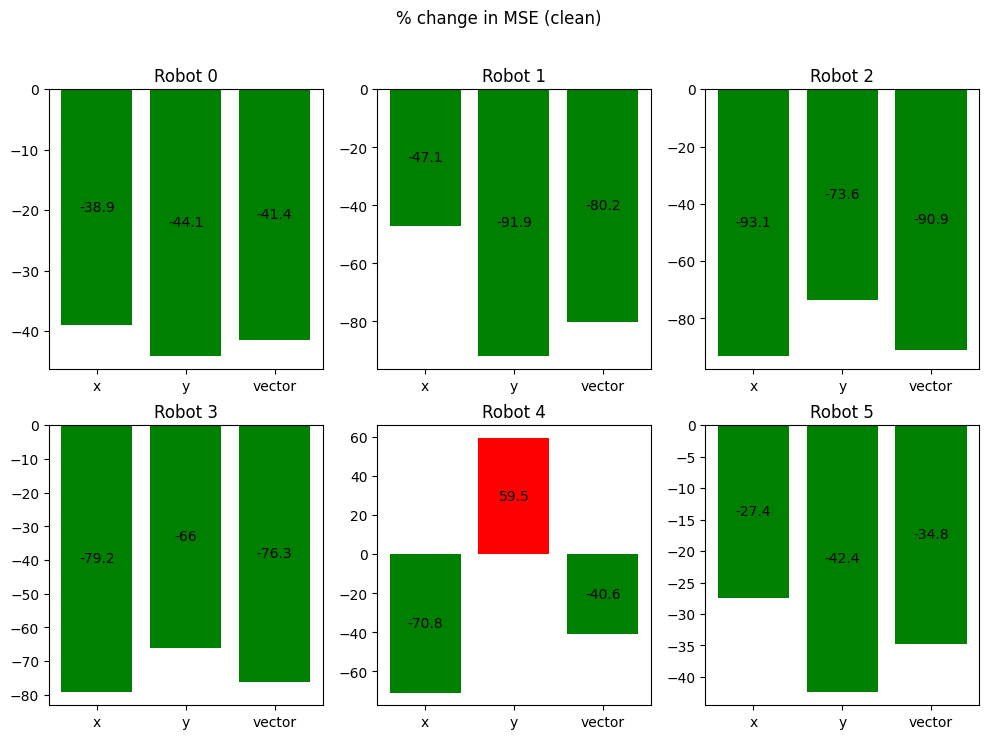

In [160]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("% change in MSE (clean)")

for id in ROBOT_RANGE:
    baseline_x, baseline_y, baseline_v = baseline_xs[id], baseline_ys[id], baseline_vs[id]

    error_x = mean_squared_error(
        CLEAN_FD,
        NOISY_KALMAN_FD,
        X_COL,
        id
    )
    
    error_y = mean_squared_error(
        CLEAN_FD,
        NOISY_KALMAN_FD,
        Y_COL,
        id
    )
    
    error_v = mean_squared_error_vec(
        CLEAN_FD,
        NOISY_KALMAN_FD,
        id
    )
    
    delta_x = percentage_diff(baseline_x, error_x)
    delta_y = percentage_diff(baseline_y, error_y)
    delta_v = percentage_diff(baseline_v, error_v)
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    
    deltas = [delta_x, delta_y, delta_v]
    colours = ['red' if d > 0 else 'green' for d in deltas]
    bars = current_ax.bar([X_COL, Y_COL, V_COL], deltas, color=colours)
    current_ax.bar_label(bars, label_type='center')